In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load the location dataset

data_path = "../data/interim/location_data.csv"

df_reader = pd.read_csv(data_path, chunksize=100000)

df_reader

In [ ]:
# do sampling and get 500 sample data in each chunks

all_samples = []

df_reader = pd.read_csv(data_path, chunksize=100000) # call chunksize again Because the previous chunks iterator is exhausted after one full use, so you need to call it again to create a new one.

for df in df_reader:
    all_samples.append(df.sample(500))


sample_df = pd.concat(all_samples, axis=0)

In [4]:
# size of sample df

sample_df.shape

(168000, 2)

In [5]:
sample_df

,pickup_latitude,pickup_longitude
48226,40.761234,-73.966377
69162,40.738647,-73.987885
844,40.769451,-73.863068
58706,40.777199,-73.957214
73532,40.733826,-74.006271
...,...,...
33506369,40.729305,-73.987183
33505311,40.705608,-74.017891
33501475,40.756927,-73.984558
33504691,40.750710,-73.986801


Text(0, 0.5, 'Longitude')

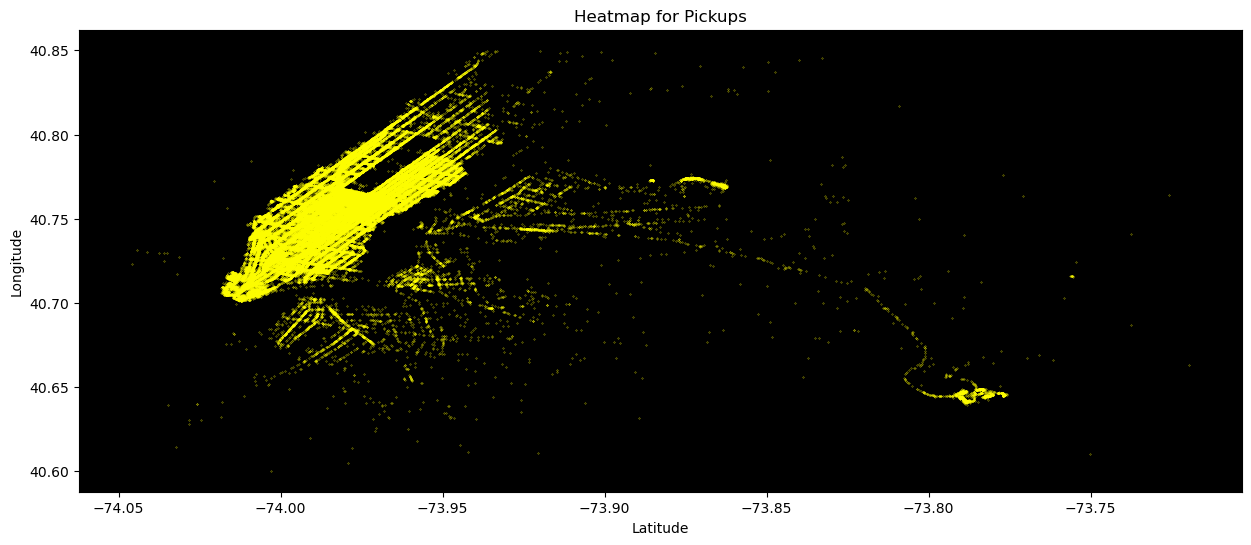

In [ ]:
# plot the dataset on a scatterplot

fig,ax = plt.subplots(nrows=1,ncols=1,sharey=True,
                     figsize=(15,6)) # sharey=True means if there were multiple plots, they'd share the same Y-axis (not critical here since only one plot)

ax.set_facecolor('k') # k use for black color
ax.scatter(sample_df['pickup_longitude'],sample_df['pickup_latitude'],s=0.05,color='yellow') # s=0.05 makes each point tiny (good for dense data like taxi pickups)
ax.set_title('Heatmap for Pickups')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

In [ ]:
from sklearn import set_config # It configures scikit-learn to return pandas DataFrames (instead of NumPy arrays) when calling .transform() on transformers.

set_config(transform_output='pandas')

In [7]:
# scale the input columns

from sklearn.preprocessing import StandardScaler

scale_samples = StandardScaler()

scaled_sample_df = scale_samples.fit_transform(sample_df)

In [8]:
scaled_sample_df

,pickup_latitude,pickup_longitude
48226,0.368495,0.200496
69162,-0.450930,-0.378308
844,0.666593,2.980763
58706,0.947669,0.447088
73532,-0.625858,-0.873134
...,...,...
33506369,-0.789854,-0.359418
33505311,-1.649551,-1.185840
33501475,0.212249,-0.288787
33504691,-0.013331,-0.349152


Text(0, 0.5, 'Longitude')

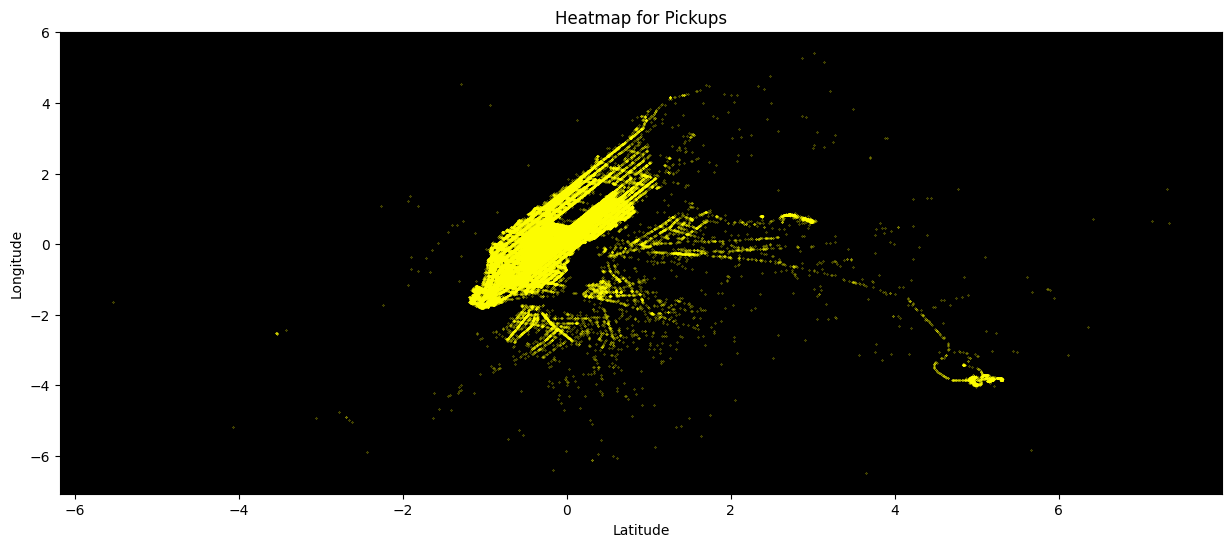

In [9]:
# plot the dataset on a scatterplot

fig,ax = plt.subplots(nrows=1,ncols=1,sharey=True,
                     figsize=(15,6))

ax.set_facecolor('k')
ax.scatter(scaled_sample_df['pickup_longitude'],scaled_sample_df['pickup_latitude'],s=0.05,color='yellow')
ax.set_title('Heatmap for Pickups')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

As can see above before or after scaling data distibution is same

In [10]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

In [11]:
df_reader = pd.read_csv(data_path, chunksize=100000)

In [ ]:
# train the standard scaler

scaler = StandardScaler()

for chunk in df_reader:
    # partial_fit is used for incremental learning on mini-batches of data without retraining from scratch, unlike fit which trains on the entire dataset at once.
    scaler.partial_fit(chunk)

In [13]:
scaler

StandardScaler()

In [14]:
# get the scaler std and mean

print("The mean values are ", scaler.mean_)
print("The sigma values are ", scaler.scale_ )

The mean values are  [ 40.75112179 -73.97394834]
The sigma values are  [0.02749352 0.03699744]


If you're dealing with coordinates on a flat plane, like in a 2D feature space (for instance, for features in a machine learning model), Euclidean distance is fine. But for real-world distances on Earth, Haversine distance is the correct choice.

In [15]:
def haversine_distance(lat1:float, lon1:float, lat2:float, lon2:float):
    """
    Calculate haversine distances between two points given their latitude and
    longitude coordinates
    """
    
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(
        dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    
    earth_radius = 3958.8
    distance = earth_radius * c
    return distance

In [16]:
def select_optimum_k(k_values):
    for k in k_values:
        df_reader = pd.read_csv(data_path, chunksize=100000)
        mini_batch = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=42)
        
        for chunk in df_reader:
            # scale the chunk
            scaled_chunk = scaler.transform(chunk)
            # train the model
            mini_batch.partial_fit(scaled_chunk)
            
        # centroid values
        centroids = scaler.inverse_transform(mini_batch.cluster_centers_)
        # calculate distances
        all_distances = []
        for i in centroids:
            distances = []
            for j in centroids:
                distance = haversine_distance(i[0], i[1], j[0], j[1])
                distances.append(distance)
            all_distances.append(distances)
        all_distances = np.array(all_distances)
        # sort array
        sorted_distances = np.sort(all_distances, axis=-1)
        # nearby regions
        region_count = 8
        # selected distances
        selected_distances = sorted_distances[:, 1:region_count+1]
        # average distances
        avg_distances = selected_distances.mean(axis=1)
        # count averages that fit criteria
        counter = ((avg_distances >= 1.0) & (avg_distances <= 1.5)).sum()
        percentage = ((avg_distances >= 1.0) & (avg_distances <= 1.5)).mean()
        print(f"For {k} clusters, the number of nearby regions that fits criteria are {counter} and is {percentage * 100:.1f}% regions of total")

In [17]:
possible_k_values = np.arange(10,100,10)

possible_k_values

array([10, 20, 30, 40, 50, 60, 70, 80, 90])

In [18]:
# select the optimum value of K

select_optimum_k(k_values=possible_k_values)

For 10 clusters, the number of nearby regions that fits criteria are 0 and is 0.0% regions of total
For 20 clusters, the number of nearby regions that fits criteria are 6 and is 30.0% regions of total
For 30 clusters, the number of nearby regions that fits criteria are 14 and is 46.7% regions of total
For 40 clusters, the number of nearby regions that fits criteria are 8 and is 20.0% regions of total
For 50 clusters, the number of nearby regions that fits criteria are 11 and is 22.0% regions of total
For 60 clusters, the number of nearby regions that fits criteria are 8 and is 13.3% regions of total
For 70 clusters, the number of nearby regions that fits criteria are 11 and is 15.7% regions of total
For 80 clusters, the number of nearby regions that fits criteria are 10 and is 12.5% regions of total
For 90 clusters, the number of nearby regions that fits criteria are 9 and is 10.0% regions of total


Lets break this select_optimum_k() function

In [19]:
df_reader = pd.read_csv(data_path, chunksize=100000)
mini_batch = MiniBatchKMeans(n_clusters=30, n_init=10, random_state=42)

for chunk in df_reader:
    # scale the chunk
    scaled_chunk = scaler.transform(chunk)
    # train the model
    mini_batch.partial_fit(scaled_chunk)
    
# centroid values
centroids = mini_batch.cluster_centers_

centroids

array([[ 1.70342493,  0.18642959],
       [-0.67075587, -0.35177119],
       [-3.81183522,  5.11850191],
       [ 0.0608276 , -0.10292805],
       [-1.29843194,  0.52269651],
       [-0.46362509,  2.71415138],
       [ 1.11670722,  0.52328062],
       [ 0.48487632, -0.20148132],
       [-2.24647062, -0.38442735],
       [-1.43454287, -0.98330275],
       [ 0.89564208,  0.68843216],
       [ 0.75850681,  2.82959671],
       [-2.12870737,  1.36345347],
       [-0.52675772, -0.77246111],
       [-1.03150349, -0.56473248],
       [ 2.32579364,  0.6065199 ],
       [ 0.25830636,  0.10311893],
       [ 1.31260769, -0.01483315],
       [ 0.4970304 ,  0.263637  ],
       [-0.10687593, -0.54734132],
       [ 0.8450349 , -0.2705767 ],
       [-0.28612272, -0.22760615],
       [ 3.37825534,  1.15785545],
       [-2.47892914,  0.34947079],
       [ 1.04256703, -0.13209708],
       [ 0.16345267,  1.30243552],
       [ 0.27029805, -0.46540404],
       [ 1.67420893,  0.82870783],
       [-3.39273097,

In [ ]:
# as above centroids values are scaled so we need every region latitude or logitute value use do invers
centroids = scaler.inverse_transform(mini_batch.cluster_centers_)

centroids.shape

centroids # now we have actual region centroid values latitude or logitute value  which center of 30 region

array([[ 40.79795494, -73.96705092],
       [ 40.73268035, -73.98696297],
       [ 40.64632103, -73.78457689],
       [ 40.75279416, -73.97775642],
       [ 40.71542333, -73.95460991],
       [ 40.73837511, -73.8735317 ],
       [ 40.781824  , -73.9545883 ],
       [ 40.76445275, -73.98140263],
       [ 40.68935841, -73.98817117],
       [ 40.71168116, -74.01032802],
       [ 40.77574614, -73.94847812],
       [ 40.77197581, -73.86926052],
       [ 40.69259614, -73.92350406],
       [ 40.73663937, -74.00252742],
       [ 40.72276213, -73.994842  ],
       [ 40.81506604, -73.95150866],
       [ 40.75822354, -73.97013321],
       [ 40.78721   , -73.97449713],
       [ 40.76478691, -73.96419445],
       [ 40.7481834 , -73.99419857],
       [ 40.77435477, -73.98395899],
       [ 40.74325527, -73.98236919],
       [ 40.84400192, -73.93111066],
       [ 40.68296731, -73.96101882],
       [ 40.77978563, -73.97883559],
       [ 40.75561568, -73.92576157],
       [ 40.75855324, -73.9911671 ],
 

In [ ]:
# calculate distances each centroid to each other
all_distances = []
for i in centroids:
    distances = []
    for j in centroids:
        distance = haversine_distance(i[0], i[1], j[0], j[1])
        distances.append(distance)
    all_distances.append(distances)
all_distances = np.array(all_distances)

In [38]:
display(all_distances.shape,all_distances)

(30, 30)

array([[ 0.        ,  4.62889874, 14.17995074,  3.17022164,  5.73950142,
         6.39495373,  1.29122283,  2.43353842,  7.58439556,  6.37685633,
         1.81624044,  5.42173906,  7.62823283,  4.62545033,  5.39512554,
         1.43474318,  2.74993744,  0.83838701,  2.29658263,  3.72075203,
         1.85509411,  3.86348819,  3.69511679,  7.95123911,  1.39859414,
         3.63662322,  3.00061527,  1.24416319,  9.71000357,  1.85095251],
       [ 4.62889874,  0.        , 12.1668178 ,  1.47094215,  2.07166124,
         5.95167596,  3.79482452,  2.21449474,  2.99395909,  1.8979349 ,
         3.59326204,  6.73246505,  4.32623643,  0.85956926,  0.79988883,
         5.98702862,  1.97254883,  3.82374378,  2.51824754,  1.13617058,
         2.88374585,  0.76922652,  8.22791682,  3.69389945,  3.2823757 ,
         3.57426359,  1.80115855,  5.00671099,  5.1789544 ,  3.11632415],
       [14.17995074, 12.1668178 ,  0.        , 12.51083077, 10.10804279,
         7.88493689, 12.92022992, 13.14934865, 11

In [23]:
# sort array
sorted_distances = np.sort(all_distances, axis=-1)

sorted_distances

array([[ 0.        ,  0.83838701,  1.24416319,  1.29122283,  1.39859414,
         1.43474318,  1.81624044,  1.85095251,  1.85509411,  2.29658263,
         2.43353842,  2.74993744,  3.00061527,  3.17022164,  3.63662322,
         3.69511679,  3.72075203,  3.86348819,  4.62545033,  4.62889874,
         5.39512554,  5.42173906,  5.73950142,  6.37685633,  6.39495373,
         7.58439556,  7.62823283,  7.95123911,  9.71000357, 14.17995074],
       [ 0.        ,  0.76922652,  0.79988883,  0.85956926,  1.13617058,
         1.47094215,  1.80115855,  1.8979349 ,  1.97254883,  2.07166124,
         2.21449474,  2.51824754,  2.88374585,  2.99395909,  3.11632415,
         3.2823757 ,  3.57426359,  3.59326204,  3.69389945,  3.79482452,
         3.82374378,  4.32623643,  4.62889874,  5.00671099,  5.1789544 ,
         5.95167596,  5.98702862,  6.73246505,  8.22791682, 12.1668178 ],
       [ 0.        ,  7.88493689,  7.95182812,  9.587776  ,  9.74932772,
        10.10804279, 10.34860461, 10.56978911, 11

In [24]:
# nearby regions
region_count = 8
# selected distances
selected_distances = sorted_distances[:, 1:region_count+1]
# average distances
avg_distances = selected_distances.mean(axis=1)

In [25]:
selected_distances

array([[ 0.83838701,  1.24416319,  1.29122283,  1.39859414,  1.43474318,
         1.81624044,  1.85095251,  1.85509411],
       [ 0.76922652,  0.79988883,  0.85956926,  1.13617058,  1.47094215,
         1.80115855,  1.8979349 ,  1.97254883],
       [ 7.88493689,  7.95182812,  9.587776  ,  9.74932772, 10.10804279,
        10.34860461, 10.56978911, 11.0765584 ],
       [ 0.54765176,  0.70191708,  0.80684651,  0.82783485,  0.91770049,
         1.09106264,  1.47094215,  1.5246648 ],
       [ 2.07166124,  2.16701761,  2.26750978,  2.26765935,  2.41051235,
         2.51670211,  2.85234043,  2.9059023 ],
       [ 2.33234839,  2.9822466 ,  4.10536234,  4.53189251,  4.69611787,
         4.99426467,  5.08426552,  5.19692012],
       [ 0.52778194,  0.69676841,  1.10603758,  1.21285825,  1.27638855,
         1.27998434,  1.29122283,  1.62105202],
       [ 0.65367582,  0.69712608,  0.73012566,  0.82783485,  0.9008305 ,
         1.06789284,  1.30849465,  1.33510824],
       [ 1.48956637,  1.93027344

In [26]:
avg_distances

array([1.46617468, 1.33842995, 9.65960795, 0.98607753, 2.43241315,
       4.24042725, 1.12651174, 0.94013608, 2.52730555, 2.27364954,
       1.29609076, 4.15977942, 3.58416741, 1.41068368, 1.62900536,
       2.26501428, 1.00766534, 1.21361087, 1.00693864, 1.11333554,
       1.09763787, 1.09026084, 4.16488631, 2.79888092, 1.10342919,
       2.4178601 , 1.08525552, 1.70501417, 3.95305015, 1.03523213])

In [27]:
((avg_distances >= 1.0) & (avg_distances <= 1.5)).mean()

0.4666666666666667

# Clustering

In [28]:
df_reader = pd.read_csv(data_path, chunksize=100000)

In [29]:
# train the model

mini_batch = MiniBatchKMeans(n_clusters=30, n_init=10, random_state=42)

for chunk in df_reader:
    # scale the chunk
    scaled_chunk = scaler.transform(chunk)
    # train the model
    mini_batch.partial_fit(scaled_chunk)

In [30]:
mini_batch

MiniBatchKMeans(n_clusters=30, n_init=10, random_state=42)

In [31]:
# centroids of the model

mini_batch.cluster_centers_

array([[ 1.70342493,  0.18642959],
       [-0.67075587, -0.35177119],
       [-3.81183522,  5.11850191],
       [ 0.0608276 , -0.10292805],
       [-1.29843194,  0.52269651],
       [-0.46362509,  2.71415138],
       [ 1.11670722,  0.52328062],
       [ 0.48487632, -0.20148132],
       [-2.24647062, -0.38442735],
       [-1.43454287, -0.98330275],
       [ 0.89564208,  0.68843216],
       [ 0.75850681,  2.82959671],
       [-2.12870737,  1.36345347],
       [-0.52675772, -0.77246111],
       [-1.03150349, -0.56473248],
       [ 2.32579364,  0.6065199 ],
       [ 0.25830636,  0.10311893],
       [ 1.31260769, -0.01483315],
       [ 0.4970304 ,  0.263637  ],
       [-0.10687593, -0.54734132],
       [ 0.8450349 , -0.2705767 ],
       [-0.28612272, -0.22760615],
       [ 3.37825534,  1.15785545],
       [-2.47892914,  0.34947079],
       [ 1.04256703, -0.13209708],
       [ 0.16345267,  1.30243552],
       [ 0.27029805, -0.46540404],
       [ 1.67420893,  0.82870783],
       [-3.39273097,

In [32]:
scaler.inverse_transform(mini_batch.cluster_centers_)

array([[ 40.79795494, -73.96705092],
       [ 40.73268035, -73.98696297],
       [ 40.64632103, -73.78457689],
       [ 40.75279416, -73.97775642],
       [ 40.71542333, -73.95460991],
       [ 40.73837511, -73.8735317 ],
       [ 40.781824  , -73.9545883 ],
       [ 40.76445275, -73.98140263],
       [ 40.68935841, -73.98817117],
       [ 40.71168116, -74.01032802],
       [ 40.77574614, -73.94847812],
       [ 40.77197581, -73.86926052],
       [ 40.69259614, -73.92350406],
       [ 40.73663937, -74.00252742],
       [ 40.72276213, -73.994842  ],
       [ 40.81506604, -73.95150866],
       [ 40.75822354, -73.97013321],
       [ 40.78721   , -73.97449713],
       [ 40.76478691, -73.96419445],
       [ 40.7481834 , -73.99419857],
       [ 40.77435477, -73.98395899],
       [ 40.74325527, -73.98236919],
       [ 40.84400192, -73.93111066],
       [ 40.68296731, -73.96101882],
       [ 40.77978563, -73.97883559],
       [ 40.75561568, -73.92576157],
       [ 40.75855324, -73.9911671 ],
 

In [33]:
# perform predictions and assign clusters

sample_predictions = mini_batch.predict(scaled_sample_df)

sample_predictions.shape

(168000,)

In [34]:
np.unique(sample_predictions)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32)

SyntaxError: invalid syntax (304270658.py, line 1)

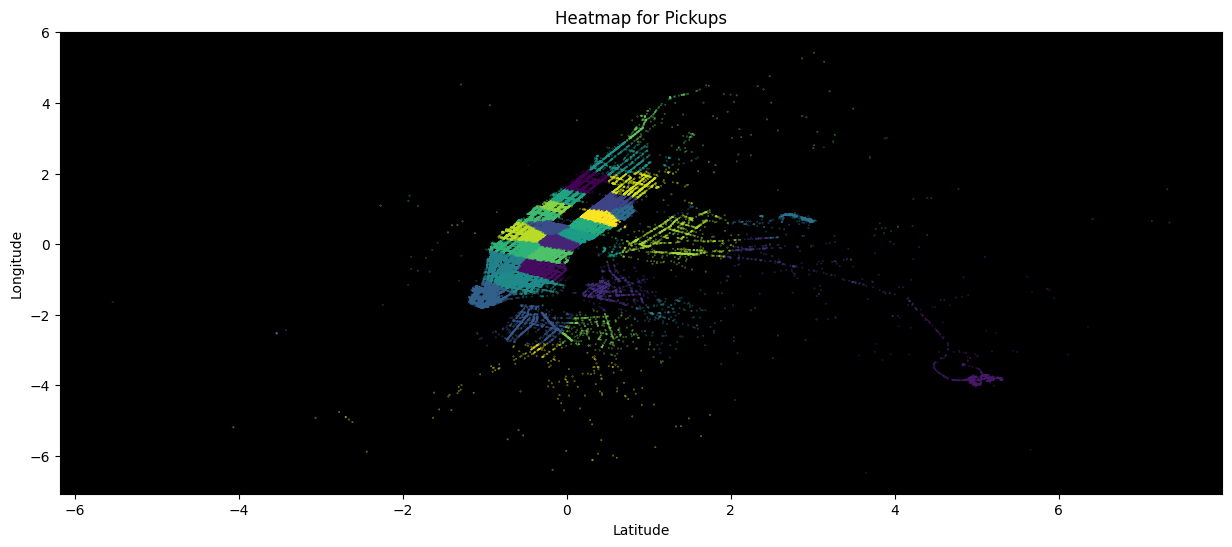

In [37]:
# plot the dataset on a scatterplot

fig,ax = plt.subplots(nrows=1,ncols=1,sharey=True,
                     figsize=(15,6))

ax.set_facecolor('k')
ax.scatter(scaled_sample_df['pickup_longitude'],scaled_sample_df['pickup_latitude'],
           s=0.05,c=sample_predictions)
ax.set_title('Heatmap for Pickups')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

plt.show()